<a href="https://colab.research.google.com/github/Seelan444/Text_Generation/blob/main/Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as plt
import os

# Step 1: Load the dataset
dataset, info = tfds.load('tiny_shakespeare', with_info=True, as_supervised=False)
text = next(iter(dataset['train']))['text'].numpy().decode('utf-8')


# Get the training data example
shakespeare_data = dataset['train']

# View as a Python iterator
for example in shakespeare_data.take(1):
    raw_text = example['text'].numpy().decode('utf-8')
    print("📜 Sample from Tiny Shakespeare Dataset:\n")
    print(raw_text[:1000])  # First 1000 characters

print(f"\n🔢 Total characters in dataset: {len(raw_text)}")

📜 Sample from Tiny Shakespeare Dataset:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunge

In [ ]:
# Step 2: Create character mapping
vocab = sorted(set(text))
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [ ]:
# Step 3: Create training sequences
seq_length = 100
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Step 4: Prepare data pipeline
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Step 5: Define model parameters
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    return tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])

In [ ]:
# Step 6: Build & compile the training model
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [ ]:
# Step 7: Set up checkpoint saving
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
# Step 8: Train the model
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 2.9188
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 1.9039
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 1.6369
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - loss: 1.5040
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 1.4224
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 1.3661
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 1.3185
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 1.2830
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 1.2511
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 1.2127
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 1.1795
Epoch 12/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 1.1464
Epoch 13/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - loss: 1.1153
Epoch 14/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 1.0778
Epoch 15/30
155/155 ━━━━━━━━━

In [ ]:
import os
print("✅ Checkpoints:", os.listdir('./training_checkpoints'))
print("✅ Latest checkpoint path:", tf.train.latest_checkpoint('./training_checkpoints'))


✅ Checkpoints: ['ckpt_8.weights.h5', 'ckpt_27.weights.h5', 'ckpt_21.weights.h5', 'ckpt_2.weights.h5', 'ckpt_19.weights.h5', 'ckpt_20.weights.h5', 'ckpt_12.weights.h5', 'ckpt_18.weights.h5', 'ckpt_9.weights.h5', 'ckpt_25.weights.h5', 'ckpt_10.weights.h5', 'ckpt_26.weights.h5', 'ckpt_30.weights.h5', 'ckpt_7.weights.h5', 'ckpt_13.weights.h5', 'ckpt_14.weights.h5', 'ckpt_4.weights.h5', 'ckpt_22.weights.h5', 'ckpt_1.weights.h5', 'ckpt_5.weights.h5', 'ckpt_16.weights.h5', 'ckpt_3.weights.h5', 'ckpt_6.weights.h5', 'ckpt_29.weights.h5', 'ckpt_23.weights.h5', 'ckpt_24.weights.h5', 'ckpt_11.weights.h5', 'ckpt_15.weights.h5', 'ckpt_17.weights.h5', 'ckpt_28.weights.h5']
✅ Latest checkpoint path: None


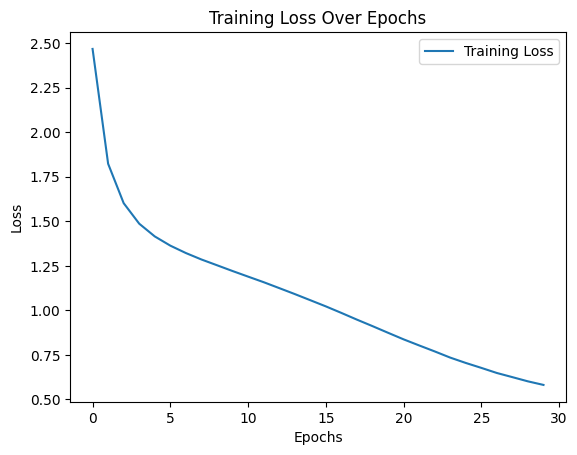

In [ ]:
# Step 9: Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:
# Step 10: Rebuild model for generation (batch size = 1)
model_gen = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

In [ ]:
import os
import re
import tensorflow as tf

# Get the latest weights file manually
def get_latest_checkpoint(path):
    files = os.listdir(path)
    ckpts = [f for f in files if f.endswith('.weights.h5')]
    if not ckpts:
        return None
    latest = max(ckpts, key=lambda f: int(re.search(r'ckpt_(\d+)', f).group(1)))
    return os.path.join(path, latest)

# Load the latest weights
checkpoint_dir = './training_checkpoints'
checkpoint_path = get_latest_checkpoint(checkpoint_dir)

if checkpoint_path:
    # Build the model with the correct input shape for generation
    model_gen = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
    # Explicitly build the model with a defined input shape
    model_gen.build(tf.TensorShape([1, None]))
    # Load the weights
    model_gen.load_weights(checkpoint_path)
    print("✅ Checkpoint loaded:", checkpoint_path)
    # Print the model summary after loading weights
    model_gen.summary()
else:
    print("❌ No checkpoint found.")

✅ Checkpoint loaded: ./training_checkpoints/ckpt_30.weights.h5


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (1, None, 256)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (1, None, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, None, 65)          │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 12: Generate text function with temperature
def generate_text(model_gen, start_string, num_generate=1000, temperature=1.0):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    # Reset states of stateful layers
    for layer in model_gen.layers:
        if hasattr(layer, 'reset_states') and layer.stateful:
            layer.reset_states()


    for _ in range(num_generate):
        predictions = model_gen(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

In [ ]:

# Step 13: Generate and print text
print("\n📝 Generated Text:\n")
print(generate_text(model_gen, start_string="QUEEN: So, lets end this", temperature=0.6))



📝 Generated Text:

QUEEN: So, lets end this braven to me; for I have heard
You should destroy his sovereign; and your brother is a comfort
Appling their fury: on the marketplace, that you now, then, bring them all.

BUSHY:
Why, that's the news with you.

Provost:
Alas, poor soul!

AUFIDIUS:
Where is thy conscience now?

SICINIUS:
This is a pals of them, and with him.

Servant:
What, think you
with him and therefore let him be a Margar't for her lip, and as
we thank the noble of my sorrow's royal kings
And harsh a double very true man's house,
Against the tide will be full of my sorrow!

KING LEWIS XI:
And let me die with continuing in the world,
I seem devotion as your father's head?

Provost:
Happily met! Has he among the town, one that is made for grace.

GLOUCESTER:
He that may chose but man? for we are soft from him,
Being a thought on Edward's easiest woman
Marcius combinets to all good words.

VOLUMNIA:
If I may live once more ing undo about the child:
And so deep as to be moved